# Notes
This code is designed for examine whether the coding property of the prior map is `heterogeneous` along the main track.

This involves 4 aspects:
1. Cross-session stability
2. Spatial Information
3. Decoding Error.
4. Field Density

In [1]:
from mylib.statistic_test import *
from mylib.decoder.NaiveBayesianDecoder import NaiveBayesDecoder

code_id = "0862 - Test Coding Property Heterogeneity"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)
pass
a = np.array([[0, 1], [2, 3]])
print(np.where(a >= 1))

        E:\Data\FinalResults\Dsp\0862 - Test Coding Property Heterogeneity is already existed!
(array([0, 1, 1], dtype=int64), array([1, 0, 1], dtype=int64))


# Decoding Loss

        E:\Data\FinalResults\Dsp\0862 - Test Coding Property Heterogeneity\Decoding Results is already existed!
16


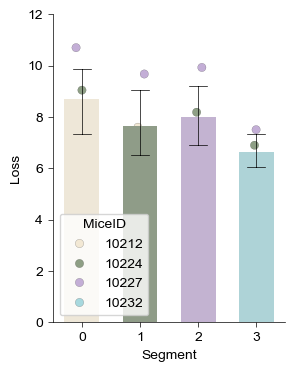

0.07954503275134307
0.36741947078334025
0.11145512748197618


F_onewayResult(statistic=1.5938131723162445, pvalue=0.24248654650287538)

In [ ]:
decode_dir = join(loc, "Decoding Results")
mkdir(decode_dir)

def gnb_decoder(trace):
    """
    Decode the trace using the GNB decoder.
    """
    beg, end = LapSplit(trace, trace['paradigm'])
    beg_t, end_t = trace['lap beg time'], trace['lap end time']
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
    
    raw_traces = trace['RawTraces']
    ms_time = trace['ms_time']
    spike_nodes = trace['spike_nodes_original']
    
    idx = np.concatenate([
        np.where(
            (ms_time >= beg_t[i]) & (ms_time <= end_t[i]) & (np.isnan(spike_nodes) == False)
        )[0] for i in np.where(routes == 0)[0]
    ])
    
    converted_spikes = np.where(raw_traces - np.std(raw_traces, axis=1)[:, np.newaxis]*3 >= 0, 1, 0)
    Spikes = converted_spikes[:, idx]
    spike_nodes = spike_nodes[idx].astype(np.int64)
    ms_time = ms_time[idx]
    
    one_fraction = int(idx.shape[0] / 5)
    start_idx = np.arange(0, idx.shape[0]+1, one_fraction)
    
    mean_loss = np.zeros((5, 4))
    D = GetDMatrices(1, 48)
    # Validate for 5 times
    for i in range(5):
        print(f"Iter {i+1}")
        test_idx = np.arange(start_idx[i], start_idx[i+1])
        train_idx = np.setdiff1d(np.arange(spike_nodes.shape[0]), test_idx)
        
        model = NaiveBayesDecoder(maze_type=1, res=48, smooth_matrix=trace['Ms'])
        model.fit(Spikes[:, train_idx], spike_nodes[train_idx])
        y_pred = model.predict(Spikes_test=Spikes[:, test_idx], MazeID_test=spike_nodes[test_idx])
        y_test = spike_nodes[test_idx]
        
        loss = D[(y_pred-1, y_test-1)]
        converted_y_test = S2F[y_test-1]
        for j, bin_range in enumerate([CP_DSP[0][:27], CP_DSP[0][27:54], CP_DSP[0][54:81], CP_DSP[3]]):
            in_range_idx = np.where(np.isin(converted_y_test, bin_range))[0]
            mean_loss[i, j] = np.nanmedian(loss[in_range_idx])
            
        print(f"  Mean Losses Are:      {mean_loss[i, 0], mean_loss[i, 1], mean_loss[i, 2], mean_loss[i, 3]}")
            
    return mean_loss


if exists(join(figdata, f"{code_id} [Decoding Loss].pkl")) == False:
    LossData = {
        "MiceID": [],
        "Session": [],
        "Loss": [],
        "Segment": []
    }
    for mouse in [10212, 10224, 10227, 10232]:
        mean_loss = np.zeros((7, 4))
        for j, i in enumerate(np.where(f2['MiceID'] == mouse)[0]):
            with open(join(decode_dir, f"Loss_{f2['MiceID'][i]}_{i}.pkl"), 'rb') as f:
                mean_loss[j, :] = np.mean(pickle.load(f), axis=0)
                
        LossData['MiceID'].append(np.repeat(mouse, 4))
        LossData['Segment'].append(np.arange(4))
        LossData['Session'].append(np.repeat(j, 4))
        LossData['Loss'].append(np.mean(mean_loss, axis=0))
            
    for k in LossData.keys():
        LossData[k] = np.concatenate(LossData[k])
        
    with open(join(figdata, f"{code_id} [Decoding Loss].pkl"), 'wb') as handle:
        pickle.dump(LossData, handle)
    
    LossD = pd.DataFrame(LossData)
    LossD.to_excel(join(figdata, f"{code_id} [Decoding Loss].xlsx"), index=False)
    print(len(LossD))
else:
    with open(join(figdata, f"{code_id} [Decoding Loss].pkl"), 'rb') as handle:
        LossData = pickle.load(handle)
"""
for j, i in enumerate(np.where(f2['MiceID'] == 10212)[0]):
    print(f2['MiceID'][i], f"S{j+1} ---------------------------")
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)

    mean_loss = gnb_decoder(trace)
    
    with open(join(decode_dir, f"Loss_{f2['MiceID'][i]}_{i}.pkl"), 'wb') as f:
        pickle.dump(mean_loss, f)
        
    print()
"""

fig = plt.figure(figsize=(3, 4))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Segment',
    y='Loss',
    hue='MiceID',
    data=LossData,
    palette=MicePaletteDSP,
    size=6,
    edgecolor='k',
    linewidth=0.1,
    jitter=0.1,
    zorder=1
)
sns.barplot(
    x='Segment',
    y='Loss',
    data=LossData,
    hue='Segment',
    palette=MicePaletteDSP,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    capsize=0.3,
    width=0.6,
    legend=False
)
ax.set_ylim(0, 12)
ax.set_yticks(np.linspace(0, 12, 7))
plt.savefig(join(loc, "Decoding Loss.png"), dpi=600)
plt.savefig(join(loc, "Decoding Loss.svg"), dpi=600)
plt.show()

# Statitsical Test
res = [[np.mean([LossData['Loss'][(LossData['Segment'] == i)&(LossData['MiceID'] == mouse)]]) for mouse in [10212, 10224, 10227, 10232]] for i in range(4)]
print(ttest_rel(res[-1], res[0]).pvalue*3)
print(ttest_rel(res[-1], res[1]).pvalue*3)
print(ttest_rel(res[-1], res[2]).pvalue*3)
f_oneway(*res)

# Spatial Information

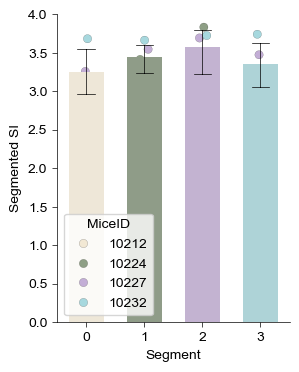

0.2230062692186328
0.7540082332196281
0.48593129509311117
F_onewayResult(statistic=0.774496742892054, pvalue=0.5303390835619836)


In [2]:
def calc_segmented_SI(trace: dict):
    SIs = np.zeros((4, 4))
    
    for j, bin_range in enumerate([CP_DSP[0][:27], CP_DSP[0][27:54], CP_DSP[0][54:81], CP_DSP[3]]):
        for k, node in enumerate([0, 4, 5, 9]):
            segment_bins = np.concatenate([Father2SonGraph[i] for i in bin_range])
            idx = np.where(np.isin(trace[f'node {node}']['spike_nodes'], segment_bins))[0]
            
            t_nodes_frac = trace[f'node {node}']['t_nodes_frac'][segment_bins-1]
            t_nodes_frac /= np.nansum(t_nodes_frac)
            t_total = np.nansum(trace[f'node {node}']['t_nodes_frac'][segment_bins-1] * trace[f'node {node}']['t_total']).sum()

            
            SI = calc_SI(
                spikes=trace[f'node {node}']['Spikes'][:, idx], 
                rate_map=trace[f'node {node}']['rate_map_all'][:, segment_bins-1], 
                t_total=t_total,
                t_nodes_frac=t_nodes_frac
            ) 
            
            SIs[j, k] = np.nanmean(SI[trace[f'node {node}']['is_placecell'] == 1])
    return np.mean(SIs, axis=1)
            
if exists(join(figdata, f"{code_id} [Segmented SI].pkl")) == False:
    SegmentedSI = { 
        "MiceID": [],
        "Session": [],
        "Segmented SI": [],
        "Segment": []
    }
    for mouse in tqdm([10212, 10224, 10227, 10232]):
        SI = np.zeros((7, 4))
        for j, i in enumerate(np.where(f2['MiceID'] == mouse)[0]):
            with open(f2['Trace File'][i], 'rb') as handle:
                trace = pickle.load(handle)
                
            SI[j, :] = calc_segmented_SI(trace)
            
        SegmentedSI['MiceID'].append(np.repeat(mouse, 4))
        SegmentedSI['Session'].append(np.repeat(j, 4))
        SegmentedSI['Segmented SI'].append(np.mean(SI, axis=0))
        SegmentedSI['Segment'].append(np.arange(4))
            
    for k in SegmentedSI.keys():
        SegmentedSI[k] = np.concatenate(SegmentedSI[k])
        
    with open(join(figdata, f"{code_id} [Segmented SI].pkl"), 'wb') as handle:
        pickle.dump(SegmentedSI, handle)
    
    SegmentedSID = pd.DataFrame(SegmentedSI)
    SegmentedSID.to_excel(join(figdata, f"{code_id} [Segmented SI].xlsx"), index=False)
    print(len(SegmentedSID))
else:
    with open(join(figdata, f"{code_id} [Segmented SI].pkl"), 'rb') as handle:
        SegmentedSI = pickle.load(handle)
        
fig = plt.figure(figsize=(3, 4))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Segment',
    y='Segmented SI',
    hue='MiceID',
    data=SegmentedSI,
    palette=MicePaletteDSP,
    size=6,
    edgecolor='k',
    linewidth=0.1,
    jitter=0.1,
    zorder=1
)

sns.barplot(
    x='Segment',
    y='Segmented SI',
    data=SegmentedSI,
    hue='Segment',
    palette=MicePaletteDSP,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    capsize=0.3,
    width=0.6,
    legend=False
)
ax.set_ylim(0, 4)
plt.savefig(join(loc, "Segmented SI.png"), dpi=600)
plt.savefig(join(loc, "Segmented SI.svg"), dpi=600)
plt.show()

# Statitsical Test
res = [SegmentedSI['Segmented SI'][SegmentedSI['Segment'] == i] for i in range(4)]
print(ttest_rel(res[-1], res[0]).pvalue*3)
print(ttest_rel(res[-1], res[1]).pvalue*3)
print(ttest_rel(res[-1], res[2]).pvalue*3)
print(f_oneway(*res))

# Field Density

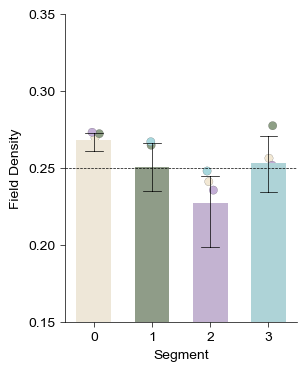

TtestResult(statistic=4.924152537998333, pvalue=0.016050220166501577, df=3)
TtestResult(statistic=0.08833820698656548, pvalue=0.9351744737357275, df=3)
TtestResult(statistic=-1.5501513776372522, pvalue=0.21888479279966186, df=3)
TtestResult(statistic=0.3213698467679342, pvalue=0.7690186064876188, df=3)


In [9]:
def count_field_density(trace):
    field_density = np.zeros((4, 4))
    field_centers = []
    for node in [0, 4, 5, 9]:
        field_centers_per_node = []
        for i in np.where(trace[f'node {node}']['is_placecell'] == 1)[0]:
            field_centers_per_node += list(trace[f'node {node}']['place_field_all'][i].keys())
        field_centers.append(np.array(field_centers_per_node, np.int64))
    
    all_bins = np.concatenate([
        np.concatenate([Father2SonGraph[i] for i in CP_DSP[0][:27]]),
        np.concatenate([Father2SonGraph[i] for i in CP_DSP[0][27:54]]),
        np.concatenate([Father2SonGraph[i] for i in CP_DSP[0][54:81]]),
        np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])
    ])
    for j, bin_range in enumerate([CP_DSP[0][:27], CP_DSP[0][27:54], CP_DSP[0][54:81], CP_DSP[3]]):
        for k, node in enumerate([0, 4, 5, 9]):
            segment_bins = np.concatenate([Father2SonGraph[i] for i in bin_range])
            
            field_density[j, k] = np.where(np.isin(field_centers[k], segment_bins))[0].shape[0] / np.where(np.isin(field_centers[k], all_bins))[0].shape[0]
    
    return np.mean(field_density, axis=1)
            
if exists(join(figdata, f"{code_id} [Field Density].pkl")) == False:
    FieldDensityData = {
        "MiceID": [],
        "Session": [],
        "Field Density": [],
        "Segment": []
    }
    
    for mouse in tqdm([10212, 10224, 10227, 10232]):
        field_density = np.zeros((7, 4))
        for j, i in enumerate(np.where(f2['MiceID'] == mouse)[0]):
            with open(f2['Trace File'][i], 'rb') as handle:
                trace = pickle.load(handle)
                
            field_density[j, :] = count_field_density(trace)
            
        FieldDensityData['MiceID'].append(np.repeat(mouse, 4))
        FieldDensityData['Session'].append(np.repeat(j, 4))
        FieldDensityData['Field Density'].append(np.mean(field_density, axis=0))
        FieldDensityData['Segment'].append(np.arange(4))
        
    for k in FieldDensityData.keys():
        FieldDensityData[k] = np.concatenate(FieldDensityData[k])
        
    with open(join(figdata, f"{code_id} [Field Density].pkl"), 'wb') as handle:
        pickle.dump(FieldDensityData, handle)
        
    FieldDensityD = pd.DataFrame(FieldDensityData)
    FieldDensityD.to_excel(join(figdata, f"{code_id} [Field Density].xlsx"), index=False)
    print(len(FieldDensityD))
else:
    with open(join(figdata, f"{code_id} [Field Density].pkl"), 'rb') as handle:
        FieldDensityData = pickle.load(handle)
        
fig = plt.figure(figsize=(3, 4))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Segment',
    y='Field Density',
    hue='MiceID',
    data=FieldDensityData,
    palette=MicePaletteDSP,
    size=6,
    edgecolor='k',
    linewidth=0.1,
    jitter=0.1,
    zorder=1,
    legend=False
)

sns.barplot(
    x='Segment',
    y='Field Density',
    data=FieldDensityData,
    hue='Segment',
    palette=MicePaletteDSP,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    capsize=0.3,
    width=0.6,
    legend=False
)
ax.set_ylim(0.15, 0.35)
ax.set_yticks(np.linspace(0.15, 0.35, 5))
ax.axhline(0.25, color='k', linestyle='--', linewidth=0.5)
plt.savefig(join(loc, "Field Density.png"), dpi=600)
plt.savefig(join(loc, "Field Density.svg"), dpi=600)
plt.show()

for i in range(4):
    print(ttest_1samp(FieldDensityData['Field Density'][FieldDensityData['Segment'] == i], 0.25))

# Segmented Cross-Session Stability

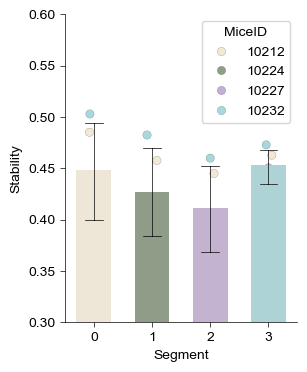

2.4088994943095563
0.6443291790229212
0.2484369022758025
F_onewayResult(statistic=0.6849648775519366, pvalue=0.5782111456955183)


In [4]:
def calc_segmented_stability(trace1, trace2, index_map):
    stability = np.zeros(4)
    
    smooth_map_all1 = np.mean(np.stack([trace1[f'node {i}']['smooth_map_all'] for i in [0, 4, 5, 9]], axis=2), axis=2)
    smooth_map_all2 = np.mean(np.stack([trace2[f'node {i}']['smooth_map_all'] for i in [0, 4, 5, 9]], axis=2), axis=2)
    
    for j, bin_range in enumerate([CP_DSP[0][:27], CP_DSP[0][27:54], CP_DSP[0][54:81], CP_DSP[3]]):
        segment_bins = np.concatenate([Father2SonGraph[i] for i in bin_range])
            
        stability[j] = np.corrcoef(
            smooth_map_all1[index_map[0, :]-1, :][:, segment_bins-1].flatten(),
            smooth_map_all2[index_map[1, :]-1, :][:, segment_bins-1].flatten()
        )[0, 1]
    
    return stability

if exists(join(figdata, f"{code_id} [Stability].pkl")) == False:
    StabilityData = {
        "MiceID": [],
        "Session": [],
        "Stability": [],
        "Segment": []
    }        
    
    for mouse in tqdm([10212, 10224, 10227, 10232]):
        with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID']==mouse)[0][0]], 'rb') as handle:
            index_map = pickle.load(handle).astype(np.int64)
        
        if mouse != 10232:
            index_map = index_map[1:, :]
            
        stability = np.zeros((7, 4))
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        for j in range(6):
            with open(f2['Trace File'][file_idx[j]], 'rb') as handle:
                trace1 = pickle.load(handle)
                
            with open(f2['Trace File'][file_idx[j+1]], 'rb') as handle:
                trace2 = pickle.load(handle)
            
            stability[j, :] = calc_segmented_stability(trace1, trace2, index_map[j:j+2, :][:, np.where((index_map[j, :] >= 1) | (index_map[j+1, :] >= 1))[0]])
            
        StabilityData['MiceID'].append(np.repeat(mouse, 4))
        StabilityData['Session'].append(np.repeat(j, 4))
        StabilityData['Stability'].append(np.mean(stability, axis=0))
        StabilityData['Segment'].append(np.arange(4))
        
    for k in StabilityData.keys():
        StabilityData[k] = np.concatenate(StabilityData[k])
        
    with open(join(figdata, f"{code_id} [Stability].pkl"), 'wb') as handle:
        pickle.dump(StabilityData, handle)
        
    StabilityD = pd.DataFrame(StabilityData)
    StabilityD.to_excel(join(figdata, f"{code_id} [Stability].xlsx"), index=False)
    
    print(len(StabilityD))
else:
    with open(join(figdata, f"{code_id} [Stability].pkl"), 'rb') as handle:
        StabilityData = pickle.load(handle)
        
fig = plt.figure(figsize=(3, 4))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Segment',
    y='Stability',
    hue='MiceID',
    data=StabilityData,
    palette=MicePaletteDSP,
    size=6,
    edgecolor='k',
    linewidth=0.1,
    jitter=0.1,
    zorder=1
)
sns.barplot(
    x='Segment',
    y='Stability',
    data=StabilityData,
    hue='Segment',
    palette=MicePaletteDSP,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    capsize=0.3,
    width=0.6,
    legend=False
)
ax.set_ylim(0.3, 0.6)
ax.set_yticks(np.linspace(0.3, 0.6, 7))
plt.savefig(join(loc, "Stability.png"), dpi=600)
plt.savefig(join(loc, "Stability.svg"), dpi=600)
plt.show()

res = [StabilityData['Stability'][StabilityData['Segment'] == i] for i in range(4)]
print(ttest_rel(res[-1], res[0]).pvalue*3)
print(ttest_rel(res[-1], res[1]).pvalue*3)
print(ttest_rel(res[-1], res[2]).pvalue*3)
print(f_oneway(*res))